---
# Import libraries
---

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 61 kB 255 kB/s 
     |████████████████████████████████| 895 kB 36.5 MB/s 
     |████████████████████████████████| 3.3 MB 30.5 MB/s 
     |████████████████████████████████| 596 kB 35.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#Fundamentals
import pandas as pd
import re
from datetime import datetime
import numpy as np

#Data visualisation
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

#NLP processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import UnigramTagger,pos_tag
from nltk import bigrams, ngrams
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

#Processing
from sklearn.model_selection import train_test_split

# Modeling
from gensim.models import Word2Vec
from transformers import pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import linear_model
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


---
# Data Importation
---

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/thomastrg/NLP_insurance_project/main/avisassurance_train.csv',sep=";")

In [ ]:
df.head()

,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto


---
# Data processing 
---

In [ ]:
df['date'] = df['date'].apply(lambda x: x.strip())

---
## Processing dates column
---

In [ ]:
def get_dates(data):
    
    reg_ = re.match("(\d+) (.+) suite à une expérience en (.+)",data).groups()
    
    return reg_[1], reg_[2]

In [ ]:
all_dates = list(df['date'].apply(get_dates))

In [ ]:
rate_date = [x[0] for x in all_dates]
exp_date = [x[1] for x in all_dates]

In [ ]:
# Number of different textual rate date and experience date
cnt = 0
for i in range(len(rate_date)):
    if rate_date[i] != exp_date[i]:
        cnt += 1
        
print(cnt)

203


---
### Mapping textual date to numeric
---

In [ ]:
tmp = pd.Series([x.split()[0] for x in rate_date]).unique()

In [ ]:
def to_dtime(data):
    
    map_month = {'janvier' : 1,
            'février' : 2,
            'mars' : 3,
            'avril' : 4,
            'mai' : 5,
            'juin' : 6,
            'juillet' : 7,
            'août' : 8,
            'septembre' : 9,
            'octobre' : 10,
            'novembre' : 11,
            'décembre' : 12}
    
    split = data.split()
    split[0] = str(map_month[split[0]])
    new_data = "/".join(split)
    return datetime.strptime(new_data,"%m/%Y")

In [ ]:
df['rate_date'] = [to_dtime(x) for x in rate_date]

In [ ]:
df['exp_date'] = [to_dtime(x) for x in exp_date]

---
### Difference between the rating date and the sinister
---

In [ ]:
def get_diff(x):
    start_date = x['exp_date']
    end_date = x['rate_date']
    return (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)

In [ ]:
df['date_difference'] = df.apply(get_diff,axis=1)

In [ ]:
df.groupby('date_difference').count()

,date,note,auteur,avis,assureur,produit,rate_date,exp_date
date_difference,,,,,,,,
0,23902,23902,23901,23901,23902,23902,23902,23902
1,73,73,73,73,73,73,73,73
2,17,17,17,17,17,17,17,17
3,17,17,17,17,17,17,17,17
4,9,9,9,9,9,9,9,9
5,9,9,9,9,9,9,9,9
6,4,4,4,4,4,4,4,4
7,8,8,8,8,8,8,8,8
8,5,5,5,5,5,5,5,5


In [ ]:
df['date'].apply(lambda x : 1 if re.match("(\d+) (.+) suite à une expérience en (.+)",x).groups() else 0)

0        1
1        1
2        1
3        1
4        1
        ..
24100    1
24101    1
24102    1
24103    1
24104    1
Name: date, Length: 24105, dtype: int64

---
## Processing reviews column
---

In [ ]:
def tokenize(x):
    try :
        return word_tokenize(x)
    except:
        return None

In [ ]:
tokenised_cat = df['avis'].apply(tokenize)

In [ ]:
#Il y avait des cas d'avis nuls donc nous les avons remplacé par une chaine de caractère vide
def handle_None():
  for i in range(len(tokenised_cat)):
    if tokenised_cat[i]==None:
      tokenised_cat[i]=""
handle_None()

On mets tous les caractères en miniscule

In [ ]:
avis_tokenized=[[x.lower() for x in el] for el in tokenised_cat] 

On enlève tous les caractères non textuels ni numériques

In [ ]:
avis_without_specials = [[x for x in el if re.match('[a-z]+',str(x))] for el in avis_tokenized]

In [ ]:
avis_without_specials = [[x for x in el if re.sub('[^a-z]+'," ",str(x))] for el in avis_without_specials]

On enlève les stopwords francais

In [ ]:
all_stopwords=stopwords.words('french')
avis_without_stopwords=[[x for x in el if x not in all_stopwords] for el in avis_without_specials]

On lemmatize les avis ensuite

In [ ]:
lemmatizer = WordNetLemmatizer()
avis_lemmetized = [[lemmatizer.lemmatize(str(word)) for word in el] for el in avis_without_stopwords]


---
## Categorize produit
---



In [ ]:
df['produit_cat']=df['produit'].astype('category').cat.codes.astype('int64')

---
## Categorize Assureur
---

In [ ]:
df['assureur_cat']=df['assureur'].astype('category').cat.codes.astype('int64')

In [ ]:
df.tail()
# Nous avons ici ajouté 2 colonnes pour remplacer les labels par des catégories

,date,note,auteur,avis,assureur,produit,rate_date,exp_date,date_difference,produit_cat,assureur_cat
24100,22 mars 2021 suite à une expérience en mars 2021,1,hophop-107522,Assurance moto chez la mutuel des motards en F...,Mutuelle des Motards,moto,2021-03-01,2021-03-01,0,7,43
24101,06 décembre 2019 suite à une expérience en déc...,1,tzl-81680,Même les demandes les plus simples n'aboutisse...,Allianz,habitation,2019-12-01,2019-12-01,0,6,8
24102,14 avril 2021 suite à une expérience en avril ...,1,jmr-72500-110395,"En décembre 2019, j'ai souscrit à un contrat C...",Cegema Assurances,sante,2021-04-01,2021-04-01,0,11,15
24103,11 juillet 2019 suite à une expérience en juil...,3,cris-77532,Je suis assurer à la gmf depuis plus de 15 ans...,GMF,auto,2019-07-01,2019-07-01,0,2,21
24104,19 janvier 2017 suite à une expérience en janv...,1,jesse-51459,Bonjour\r\nMon ami vient de se faire voler sa ...,AMV,moto,2017-01-01,2017-01-01,0,7,0


---
# Data exploration
---

In [ ]:
print('Pourcentage de valeurs nulles par colonnes :\n')
for col in df.columns:
    res = (df[col].isnull().sum() / len(df)) * 100
    res = round(res,2)
    print(f'   - {col} : {res}%')
# Aucune colonne ne contient de valeurs nulles

Pourcentage de valeurs nulles par colonnes :

   - date : 0.0%
   - note : 0.0%
   - auteur : 0.0%
   - avis : 0.0%
   - assureur : 0.0%
   - produit : 0.0%
   - rate_date : 0.0%
   - exp_date : 0.0%
   - date_difference : 0.0%
   - produit_cat : 0.0%
   - assureur_cat : 0.0%


--- 
### Exploration temporelle
---

Répartition des sinistres dans le temps

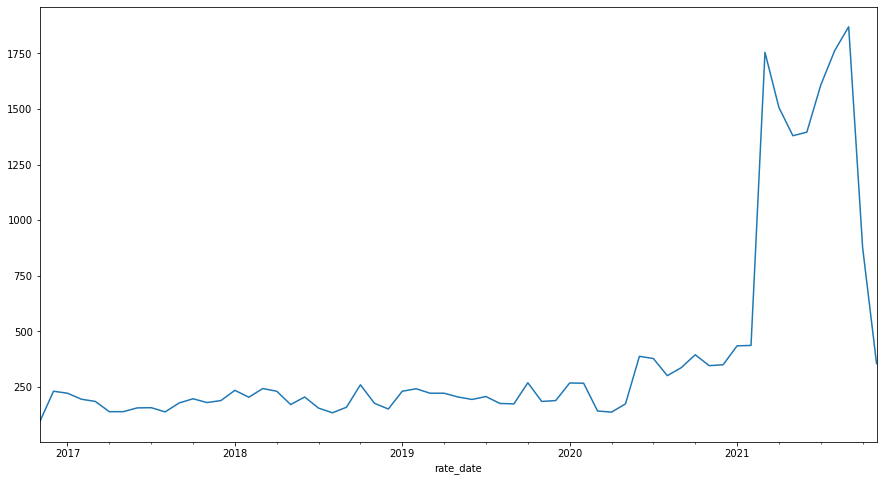

In [ ]:
plt.figure(figsize=(15,8))
df.groupby(['rate_date'])['produit'].size().plot()
# Grande hausse à partir de début 2020

Répartition des moyennes des notes dans le temps

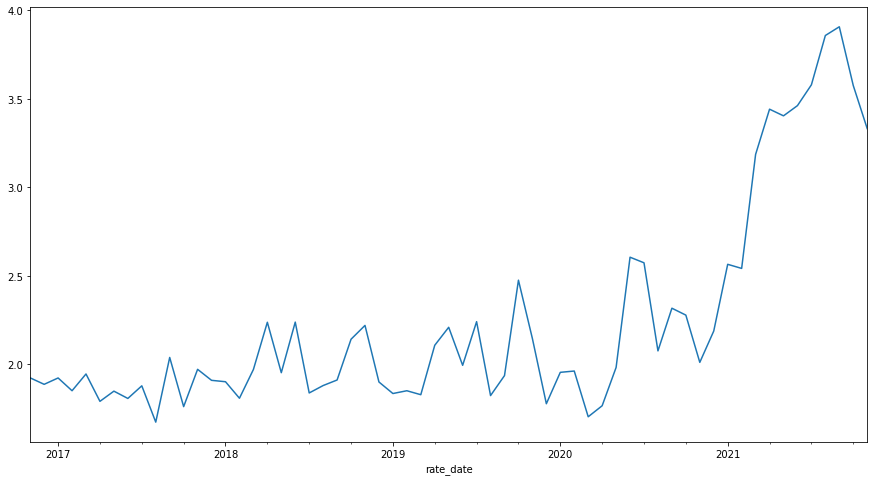

In [ ]:
plt.figure(figsize=(15,8))
df.groupby(['rate_date']).mean()['note'].plot()
# Grande hausse de la note moyenne à partir de début 2021 passant de 3 à 3.8

---
### Exploration assureurs 
---

Top 10 notation d'assureurs

In [ ]:
df1Viz_Note=pd.DataFrame(df.groupby('assureur').mean()['note'].sort_values(ascending=False))
df1Viz_Note.iloc[:10,:].style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,note
assureur,
Zen'Up,4.436735
APRIL Moto,3.946237
Mapa,3.900000
L'olivier Assurance,3.829757
AMV,3.691860
Peyrac Assurances,3.642857
MGP,3.589686
Santiane,3.468085
Direct Assurance,3.314790


Top 10 assureurs les plus utilisés

In [ ]:
df1Viz_Note=pd.DataFrame(df.groupby('assureur').count()['note'].sort_values(ascending=False))
df1Viz_Note.iloc[:10,:].style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,note
assureur,
Direct Assurance,5896
L'olivier Assurance,4288
APRIL Moto,1023
GMF,998
Néoliane Santé,861
MACIF,829
AMV,688
Santiane,658
AXA,629


--- 
### Exploration produit
---
Classement des types de produits les plus sinistrés

In [ ]:
df1=pd.DataFrame(df['produit'].value_counts())
df1.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))
# La moto est le produit le plus assuré parmi tous les produits et de très loin

,produit
auto,14077
sante,3525
moto,2105
habitation,1956
prevoyance,791
credit,653
vie,578
animaux,374
multirisque-professionnelle,20
garantie-decennale,12


Top 10 des produits qui obtiennent les meilleures notes

In [ ]:
df2Viz_Note=pd.DataFrame(df.groupby('produit').mean()['note'].sort_values(ascending=False))
df2Viz_Note.iloc[:10,:].style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,note
produit,
moto,3.501188
auto,3.145343
multirisque-professionnelle,2.850000
credit,2.647779
sante,2.531348
animaux,1.820856
habitation,1.738753
prevoyance,1.661188
garantie-decennale,1.583333


--- 
### Exploration auteur
---

In [ ]:
df2=pd.DataFrame(df['auteur'].value_counts())
df2.iloc[:10,:].style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))
# Les utilisateurs ci-dessous sont ceux qui ont le plus fait appel à leur assurance dans le dataset donné

,auteur
tontonbubu-54321,4
mikado-50419,4
pj-97010,4
mm-53953,4
roger-j-112045,3
draeni-58258,3
elbrahmi270-94179,3
misternaad-58517,3
sunny-81796,3
pipo-101088,3


In [ ]:
df_most_time_assure=df[df['auteur'].isin(df2[:10].index)]
df_most_time_assure=pd.DataFrame(df_most_time_assure.groupby('auteur').mean()['note'].sort_values(ascending=False))
_='Parmi les assurés qui ont utilisé le plus de fois leur assurance, voici la moyenne de leurs notes'
print("\033[1m" + _ + "\033[0m")
df_most_time_assure.iloc[:10,:].style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))


Parmi les assurés qui ont utilisé le plus de fois leur assurance, voici la moyenne de leurs notes


,note
auteur,
pj-97010,3.000000
tontonbubu-54321,2.500000
roger-j-112045,2.333333
pipo-101088,2.333333
draeni-58258,2.333333
mm-53953,2.250000
sunny-81796,1.333333
mikado-50419,1.250000
misternaad-58517,1.000000


--- 
### Exploration Avis
---

Wordcloud

In [ ]:
avis_lemmetized[0] 
#Voici le premier avis suite à notre traitement : c'est une liste de mots clés qui vont permettre de polariser notre reviews

['meilleurs',
 'assurance',
 'prix',
 'solution',
 'rapidité',
 'recommande',
 'cette',
 'compagnie',
 'prix',
 'attractif',
 'service',
 'qualité',
 'rapidité']

In [ ]:
len(avis_lemmetized) # Soit le nombre de reviews total

24105

In [ ]:
avis_processed=[]
for i in range(len(avis_lemmetized)):
  avis_processed.append(' '.join(avis_lemmetized[i]))

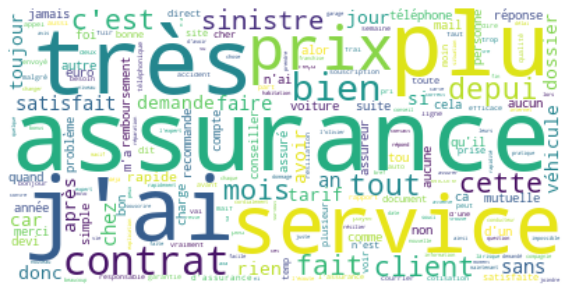

In [ ]:
wordcloud = WordCloud(stopwords = all_stopwords,collocations=False,background_color='white').generate(' '.join(avis_processed))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

<br>
<br>

---


# Modeling 


---
<br><br>



---
## Unsupervised Learning :
---
The unsupervised learning part must explain what topics are present in the dataset 

### Word embedding

In [ ]:
#Word embedding model
mymodel = Word2Vec(avis_lemmetized, min_count=1)

In [ ]:
#Bonus : Similar words, constat intéressant
mymodel.wv.most_similar("parfait")

[('nickel', 0.9645322561264038),
 ('top', 0.9467983841896057),
 ('super', 0.9359581470489502),
 ('clair', 0.9266244173049927),
 ('accessible', 0.9225284457206726),
 ('transparent', 0.919940710067749),
 ('réactif', 0.9183731079101562),
 ('satisfaisant', 0.9182208776473999),
 ('reactif', 0.9172157049179077),
 ("j'aime", 0.9141806364059448)]

In [ ]:
#Cette fonction génère un vecteur de taille 100 pour chaque avis grace au word2vec
def vectorize(list_avis, model):
    """
    Arguments:
        list_avis: List of documents
        model: Word2Vec

    Retourne un vecteur pour 1 avis
        
    """
    features = []

    for tokens in list_avis:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    


In [ ]:
vectorized_docs = vectorize(avis_lemmetized, model=mymodel)
len(vectorized_docs), len(vectorized_docs[0])

(24105, 100)

In [ ]:
vectorized_docs[0] # Voici un aperçu de la vectorisation du premier avis

array([-0.12030915,  1.5667001 ,  1.0455183 ,  0.16334309,  0.33292466,
       -0.08772627,  0.89166063, -0.2439219 , -1.6282983 ,  0.14398885,
       -0.42065904, -0.55291855,  0.66293377,  1.1156573 , -0.45299435,
       -0.09995015, -0.36699104, -0.8925717 , -0.5676291 , -0.6122607 ,
        1.2252882 ,  0.34162897, -0.33333305, -0.8314115 , -0.0702949 ,
        0.47059187, -0.7027081 ,  0.2842341 , -0.05662922,  0.03093462,
       -0.44937712, -0.15487632, -0.35760525, -0.94063866,  0.80877566,
       -0.97216266, -0.5903462 , -0.27822545, -0.07994939, -0.19290502,
       -0.39893678, -0.03985781, -0.261023  , -0.2222208 , -0.36258096,
       -0.45722383,  0.42500335, -0.03615727, -0.50143325, -0.7320779 ,
        0.05277481, -0.6671134 ,  0.831668  , -0.86723804, -0.885435  ,
        0.39766037,  0.66545355, -0.74362713,  0.40486962, -0.39682734,
        1.4609144 ,  0.8824856 ,  0.896216  , -0.19673134,  0.51624686,
       -0.7175859 ,  0.68125504,  0.6954747 , -1.01827   ,  0.75

### KMeans

In [ ]:
new_kmeans = KMeans(n_clusters=2).fit(vectorized_docs)

### Data visualisation : model performance

In [ ]:
test=df[['note','avis']]

In [ ]:
test['cluster'] = new_kmeans.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test.head()

,note,avis,cluster,polarité_KMeans,ax_1,ax_2
0,5,"Meilleurs assurances, prix, solutions, écoute,...",0,Positif,3.707660,-1.103283
1,4,"je suis globalement satisfait , sauf que vous ...",0,Positif,0.967788,1.226112
2,5,Prix tres abordable plusieurs options s'offren...,1,Négatif,0.017288,-0.809074
3,4,"je satisfait du service, une réponse très rapi...",0,Positif,3.015088,-0.315450
4,1,"Client depuis plus de 25 ans, très déçu de cet...",1,Négatif,-1.271385,-0.568267


In [ ]:
test['polarité_KMeans']=['Positif' if x ==0 else 'Négatif' for x in test['cluster']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
for i in range(10):
  print("N°"+str(i)+' - Note : '+str(df['note'][i])+' - Polarisation prédite : '+ test['polarité_KMeans'][i]+'\nAvis : '+df['avis'][i]+'\n')
  
#Parmi ces 10 premiers avis, 9 sont bien classifiés par le modèle, le seul qui n'est pas bien classifié est l'avis N°2 car le modèle a dû être trompé par le mot "zero" alors que l'avis est positif. 
#On peut comparer la note à la polarisation donnée au dessus par le KMeans

N°0 - Note : 5 - Polarisation prédite : Positif
Avis : Meilleurs assurances, prix, solutions, écoute, rapidité, et je recommande cette compagnie pour vous 
Des prix attractif et services de qualité et rapidité 

N°1 - Note : 4 - Polarisation prédite : Positif
Avis : je suis globalement satisfait , sauf que vous avez un problème avec votre site internet ,impossible de déclarer un sinistre en ligne après plusieurs tentatives déclaration faite par téléphone ou tout c'est très bien passé , interlocutrice compétente et très agréable 

N°2 - Note : 5 - Polarisation prédite : Négatif
Avis : Prix tres abordable plusieurs options s'offrent a nous comme le boitier connecter à la voiture, l'option tranquiliter et zero franchise ce qui est tout a fait plaisant

N°3 - Note : 4 - Polarisation prédite : Positif
Avis : je satisfait du service, une réponse très rapide de votre service .je vous en remercie, vous êtes une assurance la moins cher sur le marche, Cordialement. 

N°4 - Note : 1 - Polarisatio

In [ ]:
_='ON DISTINGUE DANS LES CLUSTERS QUE LE 0 REPRESENTE LES AVIS POSITIFS ET LE 1 REPRESENTE LES AVIS NEGATIFS. PARMI LES 10 PREMIERS AVIS, TOUS SONT ICI BIEN CLASSIFIES SAUF LE N°2'
print("\033[1m" + _ + "\033[91m")

ON DISTINGUE DANS LES CLUSTERS QUE LE 0 REPRESENTE LES AVIS POSITIFS ET LE 1 REPRESENTE LES AVIS NEGATIFS. PARMI LES 10 PREMIERS AVIS, TOUS SONT ICI BIEN CLASSIFIES SAUF LE N°2


In [ ]:
def print_top_10(df, col):
    res = df[col].head(20)
    for el in res:
        print(f'    - {el}')

In [ ]:
df1=pd.DataFrame(test.groupby(['polarité_KMeans','note']).size())

In [ ]:
df1.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

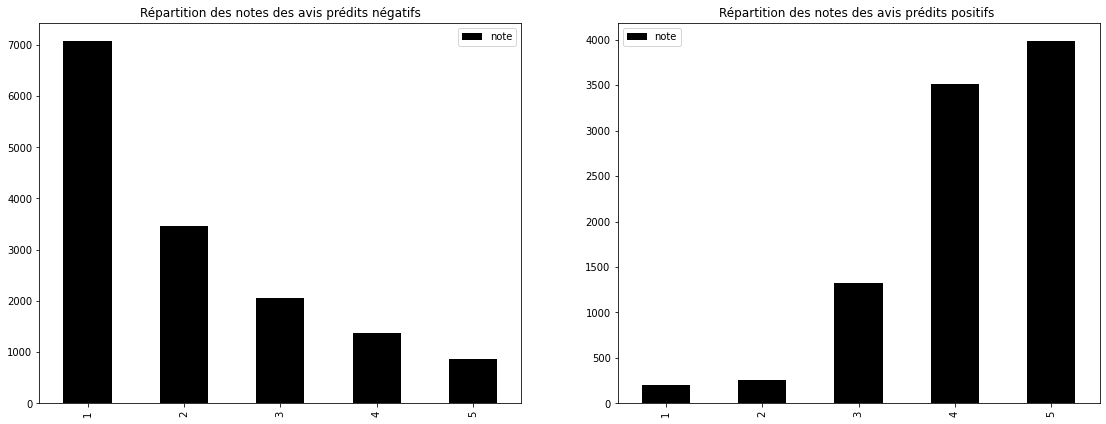

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
pd.DataFrame(test[test['polarité_KMeans']=='Négatif']['note'].value_counts(ascending=False)).plot(kind='bar',color='black',ax=axes[0],title='Répartition des notes des avis prédits négatifs',figsize=(19,7))
pd.DataFrame(test[test['polarité_KMeans']=='Positif']['note'].value_counts(ascending=True)).plot(kind='bar',color='black',ax=axes[1],title='Répartition des notes des avis prédits positifs ',figsize=(19,7))

### PCA

In [ ]:
pca = PCA(2)
res = pca.fit_transform(vectorized_docs)

In [ ]:
ax_1 = [el[0] for el in res]
ax_2 = [el[1] for el in res]
test['ax_1'] = ax_1
test['ax_2'] = ax_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


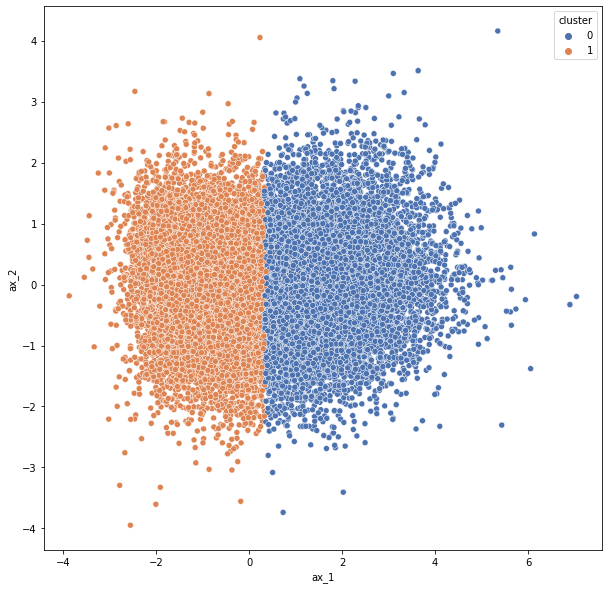

In [ ]:
fig = plt.figure(figsize=(10,10))

sns.scatterplot(x='ax_1',y='ax_2',hue='cluster',palette="deep",data=test)

---
## Supervised Learning : 
The supervised learning part must predict a rating given a review

---

### Another PCA to have 10 features instead of 100

In [ ]:
df['cluster']=test['cluster'] # On ajoute la colonne cluster que l'on a crée à l'étape précédente

In [ ]:
#Colonne que l'on veut garder pour l'apprentissage supervisé
cols_to_keep_train=['produit_cat','assureur_cat','cluster']

In [ ]:
X=df[cols_to_keep_train]
y=df['note']

In [ ]:
pca = PCA(5)
res = pca.fit_transform(vectorized_docs)

In [ ]:
print(pca.explained_variance_ratio_)
# Le premier axe contient la majorité de l'information

[0.45981998 0.12311342 0.05626144 0.05495231 0.04122773]


In [ ]:
for i in range(5):
  X['ax'+str(i)]=[el[i] for el in res]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X.head()

,produit_cat,assureur_cat,cluster,ax0,ax1,ax2,ax3,ax4
0,2,17,0,3.707660,-1.103283,0.381638,0.549722,-0.282426
1,2,17,0,0.967788,1.226112,0.584585,-0.506034,0.403858
2,2,17,1,0.017288,-0.809074,-0.688618,0.008836,0.095259
3,2,29,0,3.015088,-0.315450,1.036338,-0.004691,0.130299
4,2,39,1,-1.271385,-0.568267,-0.135590,0.253059,-0.267549


### X and Y sets 

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.27)

### Linear regression

In [ ]:
regr = linear_model.LinearRegression()
fitregr=regr.fit(X_train, y_train)
predregrtrain=fitregr.predict(X_train)
predregrtest=fitregr.predict(X_test)

In [ ]:
print('The equation of this Linear Regression has format : y= coefficient*Features + intercept')
print('Linear model intercept: {} and the coefficients are: {}'
     .format(fitregr.intercept_,fitregr.coef_))

The equation of this Linear Regression has format : y= coefficient*Features + intercept
Linear model intercept: 3.301726756347395 and the coefficients are: [-0.01114955  0.00260987 -0.76049645  0.47716514 -0.04040479 -0.06100614
 -0.04076324  0.33709964]


In [ ]:
train_set_rmse = (np.sqrt(mean_squared_error(predregrtrain,y_train )))
train_set_r2 = r2_score(y_train, predregrtrain)
print('Linear model, R2 train score is : {} and the train root mean square is: {}'
     .format(train_set_r2,train_set_rmse))

test_set_rmse = (np.sqrt(mean_squared_error(predregrtest,y_test )))
test_set_r2 = r2_score(y_test, predregrtest)
print('Linear model, R2 test score is : {} and the test root mean square is: {}'
     .format(test_set_r2,test_set_rmse))

Linear model, R2 train score is : 0.5452708031951696 and the train root mean square is: 1.0335223330658003
Linear model, R2 test score is : 0.5230576168799779 and the test root mean square is: 1.0550953610178093


### Random Forest Regressor

In [ ]:
randomForestAlgo = RandomForestRegressor()


param = {'n_estimators' : [int(x) for x in np.linspace(start=80,stop=100, num=10)], 
         'max_depth' : [90,100],
        }

gridSearch_RandomForest=GridSearchCV(randomForestAlgo,param,scoring='r2',cv=5)
gridSearch_RandomForest.fit(X_train,y_train)

best_randomForest=gridSearch_RandomForest.best_estimator_
bestRandomForest_testScore=best_randomForest.score(X_test,y_test)

In [ ]:
best_randomForest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 90,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 88,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Sur le test set crée pendant le spliting

In [ ]:
print('The best Random Forest R2 train score is : {:.2f} with n estimators = {:.2f}  \n \
'.format(gridSearch_RandomForest.best_score_,gridSearch_RandomForest.best_params_['n_estimators']))
print('The best Random Forest R2 test score is : {:.2f} with n estimators = {:.2f} \n \
'.format(bestRandomForest_testScore,gridSearch_RandomForest.best_params_['n_estimators']))

The best Random Forest R2 train score is : 0.61 with n estimators = 88.00  
 
The best Random Forest R2 test score is : 0.59 with n estimators = 88.00 
 


In [ ]:
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predregrtest))
print('Mean of the column:', np.mean(y_test))  

Mean Squared Error: 1.1132262208413013
Mean of the column: 2.8449838684897832


In [ ]:
vals=best_randomForest.feature_importances_

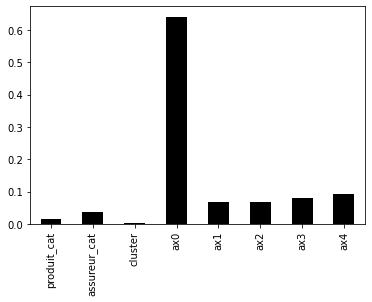

In [ ]:
pd.DataFrame(vals,index=X.columns).plot(kind='bar',legend=False,color='Black')

# Test set
## Loading the test set

In [ ]:
test_set=pd.read_csv('https://raw.githubusercontent.com/thomastrg/NLP_insurance_project/main/avisassurance_test.csv',sep=';')

In [ ]:
test_set.head()

,date,auteur,avis,assureur,produit,produit_cat,assureur_cat
0,16 novemb...,lognos-d-139728,Satisfait des tarif et rapide j'attends de voi...,L'olivier Assurance,auto,2,29
1,16 novemb...,paugam-l-139727,"Bon service, service réactif. Tout en ligne pr...",L'olivier Assurance,auto,2,29
2,16 novemb...,rozgonyi-o-139704,L’assurance Olivier est une très bonne assuran...,L'olivier Assurance,auto,2,29
3,16 novemb...,saad-hellal-h-139697,Je suis satisfait de l'olivier assurances pas ...,L'olivier Assurance,auto,2,29
4,15 novemb...,damis-s-139693,le prix est attractif par rapport à ma situati...,L'olivier Assurance,auto,2,29


## Nous devons process le test set pour pouvoir faire fonctionner le modèle
Column Avis

In [ ]:
tokenised_cat = test_set['avis'].apply(tokenize)

In [ ]:
def handle_None():
  for i in range(len(tokenised_cat)):
    if tokenised_cat[i]==None:
      tokenised_cat[i]=""
handle_None()

In [ ]:
avis_tokenized=[[x.lower() for x in el] for el in tokenised_cat] 
avis_without_specials = [[x for x in el if re.match('[a-z]+',str(x))] for el in avis_tokenized]
avis_without_specials = [[x for x in el if re.sub('[^a-z]+'," ",str(x))] for el in avis_without_specials]
all_stopwords=stopwords.words('french')
avis_without_stopwords=[[x for x in el if x not in all_stopwords] for el in avis_without_specials]
lemmatizer = WordNetLemmatizer()
avis_lemmetized = [[lemmatizer.lemmatize(str(word)) for word in el] for el in avis_without_stopwords]

Column produit

In [ ]:
test_set['produit_cat']=test_set['produit'].astype('category').cat.codes.astype('int64')

Column Assureur

In [ ]:
test_set['assureur_cat']=test_set['assureur'].astype('category').cat.codes.astype('int64')

In [ ]:
test_vectorized_docs = vectorize(avis_lemmetized, model=mymodel)
len(test_vectorized_docs), len(test_vectorized_docs[0])

(10332, 100)

## KMeans pour avoir la colonne "cluster"

In [ ]:
new_kmeans = KMeans(n_clusters=2).fit(test_vectorized_docs)

In [ ]:
test_bis=test_set[['avis']]
test_bis['cluster'] = new_kmeans.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test_bis['polarité_KMeans']=['Positif' if x ==0 else 'Négatif' for x in test_bis['cluster']] #0 positif et 1 négatif affirmatif

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_set.head()

,date,auteur,avis,assureur,produit,produit_cat,assureur_cat,cluster
0,16 novemb...,lognos-d-139728,Satisfait des tarif et rapide j'attends de voi...,L'olivier Assurance,auto,2,29,0
1,16 novemb...,paugam-l-139727,"Bon service, service réactif. Tout en ligne pr...",L'olivier Assurance,auto,2,29,0
2,16 novemb...,rozgonyi-o-139704,L’assurance Olivier est une très bonne assuran...,L'olivier Assurance,auto,2,29,0
3,16 novemb...,saad-hellal-h-139697,Je suis satisfait de l'olivier assurances pas ...,L'olivier Assurance,auto,2,29,0
4,15 novemb...,damis-s-139693,le prix est attractif par rapport à ma situati...,L'olivier Assurance,auto,2,29,0


## Apprentissage supervisé

In [ ]:
test_set['cluster']=test_bis['cluster'] 

In [ ]:
cols_to_keep_train=['produit_cat','assureur_cat','cluster']

In [ ]:
X=test_set[cols_to_keep_train]

In [ ]:
pca = PCA(5)
res = pca.fit_transform(test_vectorized_docs) # On recupere la vectorisation pour le mettre dans le test set

In [ ]:
for i in range(5):
  X['ax'+str(i)]=[el[i] for el in res]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X.head()

,produit_cat,assureur_cat,cluster,ax0,ax1,ax2,ax3,ax4
0,2,29,0,0.974181,-1.119236,0.605458,0.227694,-0.183600
1,2,29,0,1.624176,-0.009818,-0.281512,0.031769,-0.944597
2,2,29,0,2.570453,-0.430437,-0.744826,-0.123579,0.846269
3,2,29,0,1.902257,-0.368258,-0.392436,0.159538,-0.070822
4,2,29,0,0.501981,-1.558339,0.217051,-0.055696,-0.675768


### Linear Regression

In [ ]:
predregrtest=fitregr.predict(X)
predregrtest

array([3.75707194, 3.82796656, 4.93478911, ..., 1.97246267, 1.93798464,
       2.03066523])

### Random Forest regressor

In [ ]:
X=best_randomForest.predict(X)

In [ ]:
pd.DataFrame(X).to_csv('soumission_prediction.csv')